## This block of code sets the properties of the reservoir.  The commented code is for user input.  
The first block is where the user inputs the reservoir information.  Exchange the function with what's included here below in the triple-quotes to ask the user for their input.   

In [8]:
import numpy as np
from scipy import sparse

'''
def Res_properties():
    NX = int(input("Number of X grid blocks: "))
    NY = int(input("Number of Y grid blocks: "))
    L = int(input("Length of Reservoir: "))
    W = int(input("Width of Reservoir: "))
    h = int(input("Height of Reservoir: "))
    rw = float(input("Wellbore radius: "))
    dt = float(input("Change in time: "))
    mu = float(input("Fluid viscosity: "))
    Bw = float(input("Formation volume factor: "))
    ct = float(input("Rock compressibility: "))
    Pi = int(input("Initial pressure: "))
    Porosity = (np.ones([NX, NY])*0.3).T
    Permeability = (np.ones([NX, NY])*75).T
    t = int(input("Total time: "))
    n = int(input("Number of wells: "))
    
    return NX, NY, L, W, h, rw, dt, mu, Bw, ct, Pi, Porosity, Permeability, t, n'''

def Res_properties():
    NX = 99
    NY = 99

    L = 20000
    W = 20000
    h = 300
    rw = float(.25)
    dt = float(1)
    mu = float(1)
    Bw = float(1.36)
    ct = float(1e-06)
    Pi = int(3000)
    Porosity = (np.ones([NX, NY])*.3).T
    Permeability = (np.ones([NX, NY])*75).T
    t = int(100)
    n = 5

    return NX, NY, L, W, h, rw, dt, mu, Bw, ct, Pi, Porosity, Permeability, t, n

NX, NY, L, W, h, rw, dt, mu, Bw, ct, Pi, Porosity, Permeability, t, n = Res_properties()

dx = L/NX
dy = W/NY

Area_x = h*dx
Area_y = h*dy

The below T_inter function creates the intertransmisciblity of the reservoir between blocks.

In [9]:
def T_inter(Permeability, Permeability_2, mu, Bw, dx, Area):
    if Permeability == 0 or Permeability_2 == 0:
        t_inter = 0
    else:
        k_inter = 2*(1/float(Permeability) + 1/float(Permeability_2))**(-1)
        t_inter = k_inter*Area/(mu*Bw*dx)*(6.33e-03)
    return t_inter

Below, T_array creates the matrix to describe intertransmiscibility.  

In [10]:
from scipy import sparse

def T_array(NX, NY, Permeability, mu, Bw, dx, dy, Area_x, Area_y):
    N = NX*NY
    T = sparse.lil_matrix(np.zeros([N, N]))

    for i in range(N):
        if (i+1) - NX > 0:  # shows blocks above bottom edge
            T[i, i-NX] = -T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], 
                                  Permeability[3-m.floor((i)/NX),i-m.floor(i/NX)*NX],
                                mu, Bw, dy, Area_x)
            T[i, i] = T[i, i] + T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], 
                                        Permeability[3-m.floor((i)/NX),i-m.floor(i/NX)*NX],
                                mu, Bw, dy, Area_x)

            
        
        if (i+1) + NX <= N:    # shows blocks below top edge 

            T[i, i+NX] = -T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], 
                                  Permeability[1-m.floor((i)/NX),i-m.floor(i/NX)*NX],
                                mu, Bw, dy, Area_x)
            T[i, i] = T[i, i] + T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], 
                                        Permeability[1-m.floor((i)/NX),i-m.floor(i/NX)*NX],
                                mu, Bw, dy, Area_x)

            
            
        if (i+1)%NX != 0:     # Shows blocks except right edge
            T[i, i+1] = -T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX+1],
                                mu, Bw, dx, Area_y)
            T[i, i] = T[i, i] + T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], 
                                        Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX+1],
                                mu, Bw, dx, Area_y)

            
            
        if (i+1)%NX != 1:      # shows blcoks except left edge
            T[i, i-1] = -T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], 
                                 Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX-1],
                                mu, Bw, dx, Area_y)
            T[i, i] = T[i, i] + T_inter(Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX], 
                                        Permeability[2-m.floor((i)/NX),i-m.floor(i/NX)*NX-1],
                                mu, Bw, dx, Area_y)      
            
    return sparse.lil_matrix(T)

The inter_transm function creates the pressure points for each block.

In [11]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def inter_transm(Permeability, Porosity, NX, NY, t, W, L, h, mu, Bw, dt, ct, Pi, dx, dy, Q, J, B):
    T = T_array(NX,NY,Permeability,mu,Bw,dx,dy,Area_x,Area_y);
    T = sparse.lil_matrix(T);
    
    Permeability = Permeability.reshape(1, NX*NY)
    Porosity = Porosity.reshape(1, NX*NY)
    
    P_0 = np.ones([NX*NY,1])*Pi
    P_n = sparse.lil_matrix(P_0)
    
    P = np.zeros([NX*NY,t+1])
    P[:,0] = P_0.transpose()
    
    for i in range(t):
        a = T + J + B/dt
        b = np.dot((B/dt), P_n) + Q
        P_nplus1 = spsolve(a,b)
        P_n = (sparse.lil_matrix(P_nplus1)).transpose()
        P[:,i+1] = P_nplus1
    
    x = [i*L/(NX-1) for i in range(NX)]
    y = [i*W/(NY-1) for i in range(NY)]
    
    return P, x, y, T

Here is the main script to create the matrices used at the final plot. 
Ex: P_time_3 data is Pressure at time = 3 days.  

In [12]:
import math as m
from scipy import sparse
import random

NX, NY, L, W, h, rw, dt, mu, Bw, ct, Pi, Porosity, Permeability, t, n = Res_properties()

wells = np.zeros([n, 4])
Q = sparse.lil_matrix(np.zeros([NX*NY, 1]))
J = sparse.lil_matrix(np.zeros([NX*NY, NX*NY]))

x_loc = []
y_loc = []
welltype = []
oper_con = []

for i in range(n):
    x_loc = [5000, 15000, 5000, 15000, 10000]
    y_loc = [5000, 5000, 15000, 15000, 10000]
    welltype = [1, 1, 1, 1, 2]
    oper_con = [1000, 1000, 1000, 1000, 8000]
    
    # x_loc.append(int(input('X location of Well: ')))
    # y_loc.append(int(input('Y location of Well: ')))
    # welltype.append(int(input('BHP (1) or Injector (2)? ')))
    # oper_con.append(int(input('Operating condition (ft^3/day or psi): ')))
    
    wells[i,:] = [x_loc[i], y_loc[i], welltype[i], oper_con[i]]
    l = (m.ceil(y_loc[i]/dy)-1)*NX+m.ceil(x_loc[i]/dx)-1 
    if welltype[i] == 1:
        J[l,l] = (6.33e-3)*(2*m.pi*Permeability[2-m.floor((i)/3),i-m.floor(i/3)*3]*h)/(mu*Bw*m.log(.28/2*(dx**2+dy**2)**(1/2)/rw))
        Q[l] = J[l,l]*oper_con[i]
        Q = sparse.lil_matrix(Q)
    else:
        Q[l] = oper_con[i]
        Q = sparse.lil_matrix(Q)
    J = sparse.lil_matrix(J)
Q = sparse.lil_matrix(Q)
B = np.diagflat(Porosity.reshape(1,NX*NY)*dx*dy*h*ct/Bw)
B = sparse.lil_matrix(B)
P, x, y, T = inter_transm(Permeability, Porosity, NX, NY, t, W, L, h, mu, Bw, dt, ct, Pi, dx, dy, Q, J, B)

X,Y = np.meshgrid(x,y)

P_time_3 = P[:,3].reshape([NX,NY])
P_time_20 = P[:,20].reshape([NX,NY])
P_time_50 = P[:,50].reshape([NX,NY])

Q_time = np.zeros([t,welltype.count(1)])
P_time = np.zeros([t,n])

for i in range(n):
    l=(m.ceil(y_loc[i]/dy)-1)*NX+m.ceil(x_loc[i]/dx)-1
    
    if welltype[i] == 1:
        for t_p in range(t):
            Q_time[t_p,i-welltype[:i].count(2)] = J[l,l]*(P[l,t_p]-oper_con[i])
            
    elif welltype[i] == 2:
        for t_p in range(t):
            J[l,l] = 6.33e-3*(2*m.pi*Permeability[2-m.floor((i)/3),i-m.floor(i/3)*3]*h)/(mu*Bw*m.log(.28/2*(dx**2+dy**2)**(1/2)/rw))
            P_time[t_p,i] = P[l,t_p] + (oper_con[i]/J[l,l])
            


Here is the script to create the 3D plot in Matplotlib.  

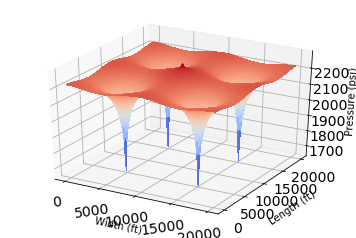

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm, colorbar

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X.T, Y.T, P_time_50, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)

ax.set_xlabel('Width (ft)')
ax.set_ylabel('Length (ft)')
ax.set_zlabel('Pressure (psi)')
plt.tick_params(axis='both', labelsize=14)
plt.xticks(rotation=8)
plt.show()


This next section is to recreate a more smooth graph in plotly.  
The 3D interactive graph is available at https://plot.ly/~keedanbarrera/2.  

In [14]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd
print(P_time_50.shape)
data = [
    go.Surface(
        z=P_time_50
    )
]

layout = go.Layout(
    title='Nichelik Field',
    autosize=False,
    width=600,
    height=500,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='elevations-3d-surface')

(99, 99)
